[![Shorenstein Logo](https://shorensteincenter.org/wp-content/uploads/2014/08/cropped-cropped-HKSlogo_shorenstein.png)](https://shorensteincenter.org/)

# Table of Contents:
###  0 [Import Libraries ](#0-bullet)
###  1 [Pull Data from the API](#1-bullet)
###  2 [Turn the Data into a pandas DataFrame](#2-bullet)
###  3 [Explore the Data](#3-bullet)
#####      - 3.1 [Basic List Composition](#3.1-bullet)
#####      - 3.2 [List Composition Over Time](#3.2-bullet)
#####      - 3.3 [Subscriber (In)Activity ](#3.3-bullet)
#####      - 3.4 [Subscriber Engagement Distributions](#3.4-bullet)
#####      - 3.5 [ Investigating Churn](#3.5-bullet)
###  4 [Export Results to a Folder](#4-bullet)

# 0. Import libraries and set global variables <a class="anchor" id="0-bullet"></a>

In [1]:
# this is a comment
# comments are used throughout this notebook to explain what is happening in each cell
# this is a cell
# the In [] to the left stands for input 
# when you click inside the cell it will turn green and you can edit the code 
# run the cells in this notebook in order by pressing shift + enter 
# you will see an input number appear on the left after the cell has run

# set colors 
c1='#18a45f' # subscribers
c2='#ec3038' # unsubscribes
c3='#3286ec' # cleaned
c4='#fecf5f' # pending
c_ev= '#cccccc' # ever opened
c_nev='#000000' # never opened

In [2]:
# import libraries
%matplotlib inline
import os
from mailchimp3 import MailChimp # import your wrapper of choice for your email service provider - in this case mailchimp3. 
import pandas as pd # standard code for importing the pandas library and aliasing it as pd - if you want to learn all about pandas read 'Python for Data Analysis' version 2nd Edition by Wes McKinney, the creator of pandas
import time # allows you to time things 
import matplotlib.pyplot as plt # allows you to plot data  
import seaborn as sns # makes the plots look nicer
import numpy as np


# 1. Pull Data from the API <a class="anchor" id="1-bullet"></a>

 [ We will pull data from the MailChimp API as an example in this notebook](https://developer.mailchimp.com/)
 ### You pull from an API, or read in your own data from a csv or other file format

In [3]:
# run this cell to define global variables to pull data from the API of your email service provider, in this case MailChimp
# and specify LIST_NAME so the files in the exported executive summary are labled correctly
# replace the variable values in quotes in red caps with the unique values for your MailChimp account
LIST_NAME='YOURLISTNAME'
NAME='YOURUSERNAME'# your MailChimp user name (used at login)
SECRET_KEY='YOURAPIKEY'# your MailChimp API Key
LIST_ID='YOURLISTID' # the ID for the individual list you want to look at
#OUT_FILE='OUTFILENAME.csv'# if you want to export your data, you can specify the outfile name and type, in this example CSV 

# Make an output directly to explort the results and images from this notebook
oupt_dir='Shorenstein_Notebook_1_'+str(LIST_NAME)

In [ ]:
# included in case the directory is already there so it doesn't error out 
try:
    os.mkdir(out_dir)
except:
    print ('e')

In [ ]:
# initalizes client - create a connection with the API; calling that connection client  
client = MailChimp(SECRET_KEY, NAME)

In [ ]:
%%time 
# %%time, this magic command above tells jupyter to time how long this cell takes to run
# magic commands have to be first which is why this comment is not first
# makes a MailChimp API call and stores the results in member_data; kernal will be busy - filled in - while data is being pulled from the API
# from the client object - created in the input directly above - we are calling the method to get all member information for members on the list you are interested in 
# names what is returned from the API member_data and specifies the fields for the API to return
# TIP: limit the fields to the ones you want speeds up the time it takes the API calls to complete
# if this times out or if you have issues, consider doing a batch request which does not require you to keep the connection open while the request processes 
# batch requests are the recommended method by MailChimp, although they are significantly slower in pulling the data, they are more robust
# for simplicity we do a normal API request in this notebook

member_data=client.lists.members.all(LIST_ID,get_all=True,
                                    fields='members.status,members.email_address,members.timestamp_opt,members.timestamp_signup,members.stats,members.id')
print("api calls done")

# 2. Turn the Data into a pandas Data Frame <a class="anchor" id="2-bullet"></a>

In [32]:
# turns the member_data returned by the API call into a pandas data frame
# pandas allows you to do a number of complex calculations 
member_data_frame=pd.DataFrame(member_data['members'])

# makes a copy of the data frame so you don't have to repull it if you make changes and want to go back to the original data
member_data_frame.to_pickle(LIST_NAME+'_members.pkl')

# look to see what the data frame looks like
# TIP: you may need to scroll to the right to see all the columns
member_data_frame.head()

,email_address,id,stats,status,timestamp_opt,timestamp_signup


# 3. Explore the Data <a class="anchor" id="3-bullet"></a>

## 3.1 Basic List Composition<a class="anchor" id="3.1-bullet"></a>
### We go from asking 'What is my list size?' 

In [6]:
# List size - number of current subscribers, as measured by unique email addresses with status of subscribed on your list
list_size=sum(member_data_frame.status=='subscribed')
print (list_size)

45972


### To asking 'What is my list composition?' 

In [7]:
# total unique email records in your list dataset
total_un_eml=member_data_frame.email_address.nunique()
print (total_un_eml)

128361


In [8]:
# explore member status by seeing the values and counts for each value returned
# MailChimp has four possible status values: subscribed, unsubscribed, pending, and cleaned 
# subscribed = current subscribers
# unsubscribed = anyone who unsubscribed themselves or you unsubscribed, e.g. due to inactivity 
# pending = if you have or have ever had double opt in enabled, pending emails are email addresses that were entered into your subscribe form, but the email confirmation link was never clicked
# cleaned = emailed that were cleaned due to bouncing. One hard bounce or about 15 soft bounces. 
member_data_frame.status.value_counts()


pending         50497
subscribed      45972
unsubscribed    17560
cleaned         14332
Name: status, dtype: int64

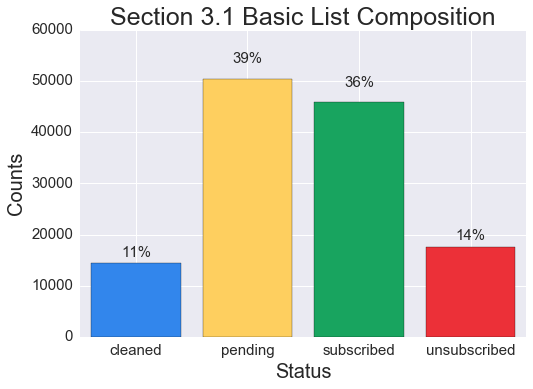

In [9]:
# store_values for later
statuses=member_data_frame.status.unique()
if 'subscribed' in statuses:
    subscribed=member_data_frame.status.value_counts()['subscribed']
else:
    subscribe=0
    print "looks like you have no subscribers something might have gone wrong."
if 'unsubscribed' in statuses:
    unsubscribed=member_data_frame.status.value_counts()['unsubscribed']
else:
    unsubscribed=0
if 'cleaned' in statuses:
    cln=member_data_frame.status.value_counts()['cleaned']
else:
    cln=0
if 'pending' in statuses:
    pndg=member_data_frame.status.value_counts()['pending']
else:
    pndg=0


bar=pd.DataFrame([['subscribed',subscribed],['unsubscribed',unsubscribed],
             ['cleaned',cln],['pending',pndg]],columns=['status','sizes'])
bar.sort_values('status',inplace=True)
objects=bar.status.tolist()
y_pos=np.arange(len(bar.status.tolist()))
performance =bar.sizes.tolist()

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                "{0:.0f}%".format(int(height)/float(bar.sizes.sum())*100),
                ha='center', va='bottom',fontsize=15)

fig, ax = plt.subplots()
ax_b=ax.bar(y_pos, performance, align='center',color=[c3,c4,c1,c2])
plt.yticks(fontsize=15)
plt.xticks(y_pos, objects, fontsize=15)
plt.ylabel('Counts',fontdict={'fontsize':20})
plt.xlabel('Status',fontdict={'fontsize':20})
plt.title('Section 3.1 Basic List Composition',fontdict={'fontsize':25})
autolabel(ax_b)
plt.savefig(oupt_dir+'/Section_3.1_ListComposition.png')
plt.show()

## 3.2 List Composition Over Time<a class="anchor" id="3.2-bullet"></a>
#### Looking at the types of emails you acquired over time, users are Subscribed, Unsubscribed, Pending or Cleaned. 

In [10]:
# prepare the data by calculating the month joined, and for each of those months, what % of those people are subscribed, unsubscribed, cleaned or pending 
# NOTE: There is no output from this cell but you need to run it to see the graphs below. 
member_data_frame['timestamp_opt']=member_data_frame.timestamp_opt.apply(pd.to_datetime)

member_data_frame['timestamp_signup']=member_data_frame.timestamp_signup.apply(pd.to_datetime)

# records missing signup_time
sum(member_data_frame.timestamp_signup.isnull())

45035

In [11]:
# make sure index is unique because we are about to do some manipulations based on it
member_data_frame.reset_index(drop=True,inplace=True)

# index of members where we don't know when they signed up but we have opt in time
guess_time_ix=member_data_frame[(member_data_frame.timestamp_signup.isnull())&
                               (member_data_frame.timestamp_opt.isnull()!=True)].index

# when we don't have signup time use opt in time
member_data_frame.loc[guess_time_ix,'timestamp_signup']=member_data_frame.loc[guess_time_ix,'timestamp_opt']

# using integer division to break down people into groups by the month they joined
member_data_frame['join_month']=member_data_frame.timestamp_signup.apply(lambda x:
                                                                         pd.to_datetime(2592000*int((x.value/1e9)/2592000),unit='s'))

# represent the joined month as an integer of ms - milliseconds - since epoch time 0
# this format is not nice for people but very nice for computers!
member_data_frame['jv']=member_data_frame.join_month.apply(lambda x: x.value)
member_data_frame['jv']=member_data_frame.join_month.apply(lambda x: x.value)

# any times we get before this we assume are data errors
mim_time=pd.to_datetime('01-01-1990')

# ignore records before mintime
member_data_frame=member_data_frame[member_data_frame.join_month>mim_time].copy()

tot=member_data_frame.groupby('join_month').size().reset_index()
sub=member_data_frame[member_data_frame.status=='subscribed'].groupby('join_month').size().reset_index()
unsub=member_data_frame[member_data_frame.status=='unsubscribed'].groupby('join_month').size().reset_index()
cleaned=member_data_frame[member_data_frame.status=='cleaned'].groupby('join_month').size().reset_index()
pending=member_data_frame[member_data_frame.status=='pending'].groupby('join_month').size().reset_index()

unsub.columns=['join_month','un']
tot.columns=['join_month','tot']
sub.columns=['join_month','sub']
cleaned.columns=['join_month','clean']
pending.columns=['join_month','pen']

comps=pd.merge(tot,unsub, how='left', on='join_month')
comps=pd.merge(comps,sub, how='left', on='join_month')
comps=pd.merge(comps,cleaned, how='left', on='join_month')
comps=pd.merge(comps,pending, how='left', on='join_month')

comps.fillna(0,inplace=True)

comps['un_per']=comps.apply(lambda x: x['un']/float(x['tot']),axis=1)
comps['sub_per']=comps.apply(lambda x: x['sub']/float(x['tot']),axis=1)
comps['cleaned_per']=comps.apply(lambda x: x['clean']/float(x['tot']),axis=1)
comps['pending_per']=comps.apply(lambda x: x['pen']/float(x['tot']),axis=1)

#### Breakdown of subscribed, unsubscribed and pending by time joined

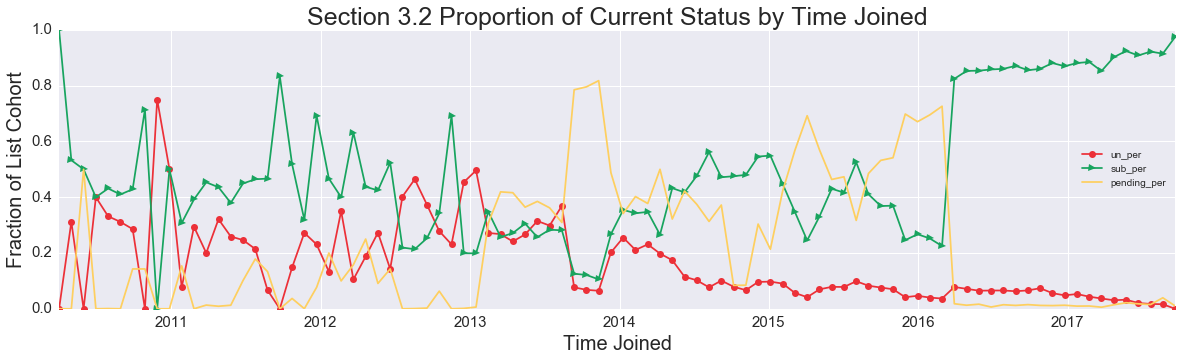

In [12]:
# green line with triangles represents currently subscribed users
# red line with circles represents unsubscribed users
# solid yellow line represents pending users
plt.figure(figsize=(20,5))
plt.plot(comps.join_month,comps.un_per,'-o',color=c2)
plt.plot(comps.join_month,comps.sub_per,'->',color=c1)
plt.plot(comps.join_month,comps.pending_per,'-',color=c4)
# plt.plot(comps.join_month,comps.cleaned_per,'^-',color=c3) 
# Usually there will be much smaller proportion of cleaned; which we plot separately to see variations 
# Can also be plotted on this graph if desired 
plt.title('Section 3.2 Proportion of Current Status by Time Joined',fontdict={'fontsize':25})
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Fraction of List Cohort',fontdict={'fontsize':20})
plt.xlabel('Time Joined',fontdict={'fontsize':20})
plt.legend(loc='best')
plt.savefig(oupt_dir+'/Section_3.2_Proportion_of_Current_Status_by_Time_Joined.png')

#### Breakdown of cleaned by time joined

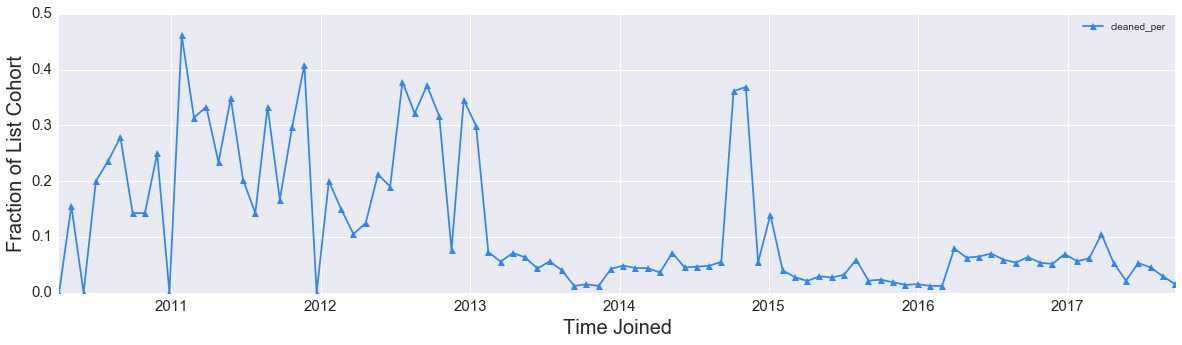

In [13]:
# Blue line represents cleaned users. NOTE: Y-Axis should be smaller than the graph above. 
# If it's close to the same magnitude as above, you likely have an issue with bounces. 
plt.figure(figsize=(20,5))
plt.plot(comps.join_month,comps.cleaned_per,'^-',color=c3)
# plt.title('Section 3.2 Proportion of Cleaned by Time Joined',fontdict={'fontsize':25})
plt.ylabel('Fraction of List Cohort',fontdict={'fontsize':20})
plt.xlabel('Time Joined',fontdict={'fontsize':20})
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig(oupt_dir+'/Section_3.2_Proportion_of_Cleaned_by_Time_Joined.png')
plt.legend(loc='best')

## Section 3.3 Subscriber (In)Activity<a class="anchor" id="3.3-bullet"></a>

In [14]:
# this cell does not have an output but you need to run it 
# unpack open rate and click rate from stats for each record, add the value to a column named open and click respectively.
# create a column for those who never opened or clicked
# false = number of subscribers who have ever opened (gray)
# true = number of subscribers who have never opened (black)
member_data_frame['open']=member_data_frame.stats.apply(lambda x: x['avg_open_rate'])
member_data_frame['click']=member_data_frame.stats.apply(lambda x: x['avg_click_rate'])

member_data_frame['never_opened']=member_data_frame.open.apply(lambda x:x==0)
member_data_frame['never_clicked']=member_data_frame.click.apply(lambda x:x==0)


# continued from above, now as three separate arrays
ever_opened=member_data_frame[(member_data_frame.status=='subscribed')&
                                (member_data_frame.never_opened!=True)]
never_opened=member_data_frame[(member_data_frame.status=='subscribed')&
                  (member_data_frame.never_opened)]

#### Opens: Ever Opened vs. Never Opened

In [15]:
# unpack individual user open rate and click rate from stats for each user record, add the value to a column named open and click respectively.
# create a column for those who never opened or clicked
# false = number of subscribers who have ever opened 
# true = number of subscribers who have never opened
member_data_frame['open']=member_data_frame.stats.apply(lambda x: x['avg_open_rate'])
member_data_frame['click']=member_data_frame.stats.apply(lambda x: x['avg_click_rate'])

member_data_frame['never_opened']=member_data_frame.open.apply(lambda x:x==0)
member_data_frame['never_clicked']=member_data_frame.click.apply(lambda x:x==0)
member_data_frame[member_data_frame.status=='subscribed'].never_opened.value_counts()

False    38932
True      7040
Name: never_opened, dtype: int64

In [16]:
# save ever_open and never open for later
ev_opn=member_data_frame[member_data_frame.status=='subscribed'].never_opened.value_counts()[False]
nv_opn=member_data_frame[member_data_frame.status=='subscribed'].never_opened.value_counts()[True]

In [17]:
# false = percent subscribers ever opened
# true = percent subscribers never opened 
member_data_frame[member_data_frame.status=='subscribed'].never_opened.value_counts()/float(list_size)

False    0.846863
True     0.153137
Name: never_opened, dtype: float64

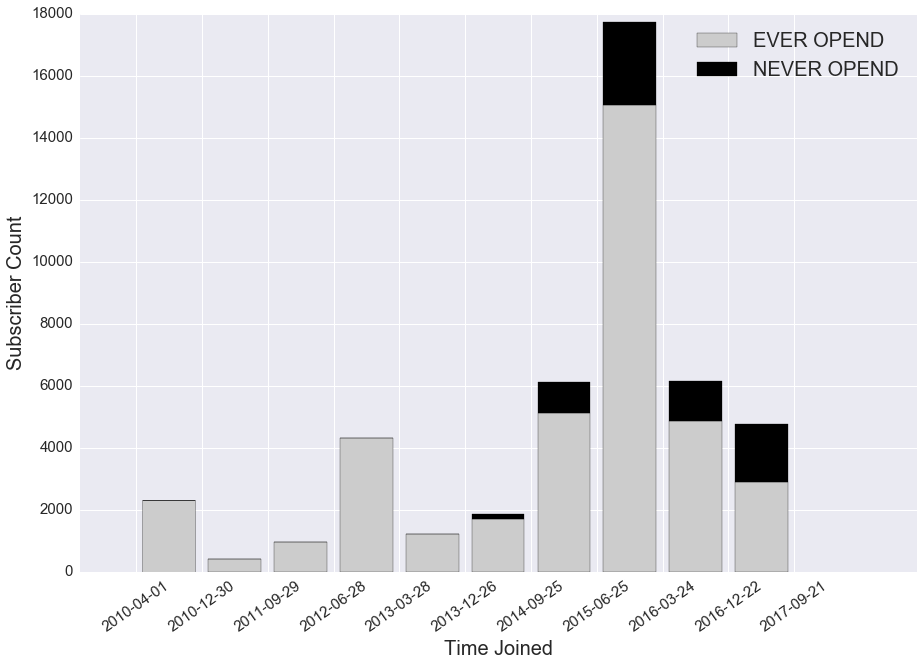

In [18]:
# stack the data - never opened vs ever opened
plt.figure(figsize=(15,10))
ax=plt.hist([ever_opened.jv,never_opened.jv], stacked=True,normed=False,label=['EVER OPEND',
                                                                               'NEVER OPEND'],color=[c_ev,c_nev])

plt.xticks(ax[1],map(lambda x: pd.to_datetime(x).date(),ax[1]), rotation=35)
#plt.title('Section 3.3 Never Opened vs EverOpened by Time Joined, Stacked Histogram',fontdict={'fontsize':25})
plt.ylabel('Subscriber Count',fontdict={'fontsize':20})
plt.xlabel('Time Joined',fontdict={'fontsize':20})
plt.legend(loc='best', prop={'size': 20})
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig(oupt_dir+'/Section_3.3_NeverOpened_vs_EverOpened_by_Time_Joined.png')
plt.show()

#### Clicks: Ever Clicked vs. Never Clicked

In [19]:
# save ever open and never open rates for later
ev_opn_r=ev_opn/float(list_size)

nv_opn_r=nv_opn/float(list_size)

In [20]:
# false = number of subscribers who have ever clicked 
# true = number of subscribers who have never clicked 
member_data_frame[member_data_frame.status=='subscribed'].never_clicked.value_counts()

False    23721
True     22251
Name: never_clicked, dtype: int64

In [21]:
# save ever clicked and never clicked for later
ev_clk=member_data_frame[member_data_frame.status=='subscribed'].never_clicked.value_counts()[False]
nv_clk=member_data_frame[member_data_frame.status=='subscribed'].never_clicked.value_counts()[True]

In [22]:
# false = percent subscribers ever clicked
# true = percent subscribers never clicked 
member_data_frame[member_data_frame.status=='subscribed'].never_clicked.value_counts()/float(list_size)


False    0.515988
True     0.484012
Name: never_clicked, dtype: float64

In [23]:
# save ever clicked and never clicked rates for later
ev_clk_r=ev_clk/float(list_size)
nv_clk_r=nv_clk/float(list_size)

## 3.4 Subscriber Engagement Distributions <a class="anchor" id="3.4-bullet"></a>
#### Distribution of average user open rate for subscribers

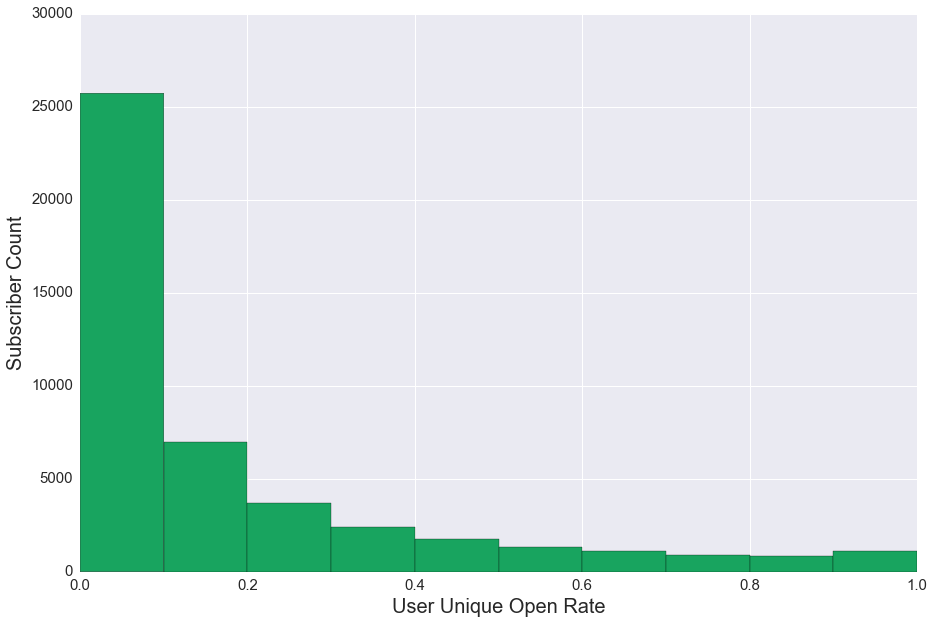

In [24]:
plt.figure(figsize=(15,10))
member_data_frame[member_data_frame.status=='subscribed'].open.hist(color=c1)
#plt.title('Section 3.4 Distribution of User Unique Open Rates',fontdict={'fontsize':25})
plt.xlabel("User Unique Open Rate",fontdict={'fontsize':20})
plt.ylabel("Subscriber Count",fontdict={'fontsize':20})
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig(oupt_dir+'/Section_3.4_Distribution_of_User_Average_Open_Rates.png')   

#### Distribution of average user click rate for subscribers

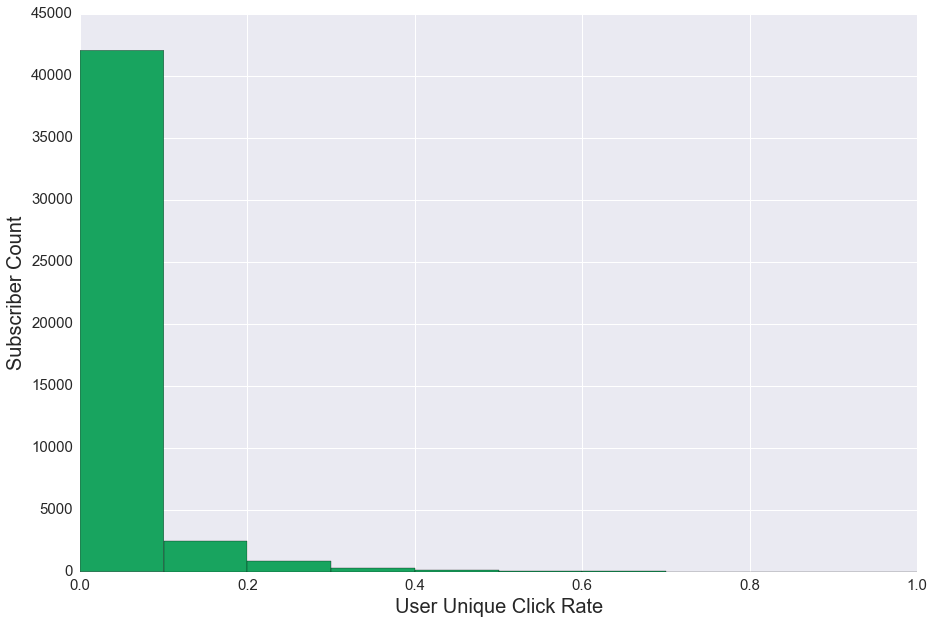

In [25]:
plt.figure(figsize=(15,10))
member_data_frame[member_data_frame.status=='subscribed'].click.hist(color=c1)
#plt.title('Section 3.4 Distribution of User Unique Click Rates',fontdict={'fontsize':25})
plt.xlabel("User Unique Click Rate",fontdict={'fontsize':20})
plt.ylabel("Subscriber Count",fontdict={'fontsize':20})
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig(oupt_dir+'/Section_3.4_Distribution_of_User_Average_Click_Rates.png')   

## Section 3.5 Investigating Churn <a class="anchor" id="3.5-bullet"></a>
#### Lifetime Unsubscribe Rate

In [26]:
# unsubscribe rate: over the lifetime of your list for everyone who successfully subscribed x% unsubscribed 
# or, another way to think about this is on average over the lifetime of your list for every 100 people who successfully subscribed, x number of people unsubscribed 
life_unsub=unsubscribed/float(unsubscribed+subscribed+cln)*100
print (life_unsub)

22.5521421967


#### Lifetime Subscribe Rate

In [27]:
# subscribe rate: over the lifetime of your list on average for everyone who successfully subscribed x% are still subscribed. 
life_sub=subscribed/float(subscribed+unsubscribed+cln)*100
print (life_sub)

59.0414055276


#### Lifetime Cleaned Rate 

In [28]:
# cleaned rate: of everyone who has ever had a status of subscribed, what been removed due to bounces?  
life_clean=cln/float(subscribed+unsubscribed+cln)*100
print (life_clean)

18.4064522758


## Section 4 Export Results of Notebook 1 to Folder  <a class="anchor" id="4-bullet"></a>
:bowtie:

In [29]:
# export data 

exec_dict={'Shorenstein Notebook 1':{
 1: u'3.1 List Composition Analysis',
 2: u'Tr12d86b1d6aaditionally measured list size',
 3: u'Total unique email records ',
 4: u'Composition of total unique email records by status ',
 10: u'3.2 List Lifetime Ratios',
 11: u'Lifetime Unsubscribe Rate',
 12: u'Lifetime Subscribe Rate',
 13: u'Lifetime Cleaned Rate',
 15: u'Section 3.3 Reader Activity',
 16: u'Ever Opened',
 17: u'Never Opened',
 19: u'Ever Clicked',
 20: u'Never Clicked'},
          '1':{2:list_size,3:total_un_eml,5: u'subscribed',
                             6: u'unsubscribed',7: u'cleaned',8: u'pending',
                           11:life_unsub,
                           12:life_sub,
                           13:life_clean,
                            16:ev_opn,
                            17:nv_opn,
                            19:ev_clk,
                            20:nv_clk},
          "2":{5:subscribed,
                                6:unsubscribed,
                                7:cln,
                                8:pndg,
                                16:ev_opn_r,
                                17:nv_opn_r,
                                19:ev_clk_r,
                                20:nv_clk_r}}

ex_rpt=pd.DataFrame(exec_dict)

ex_rpt['']=ex_rpt['1']

ex_rpt[' ']=ex_rpt['2']

del ex_rpt["1"]
del ex_rpt["2"]

In [ ]:
ex_rpt.to_csv(oupt_dir+'/Shorenstein Notebook 1 executive report.csv',index=False)